## 1. DataSet import

In [1]:
import torch
from torch import nn
from sklearn.model_selection import train_test_split
from prepare_datasets import *
from Helper_functions import *

X, y, feature_names, categorical_features, continuous_features, actionable_features= get_and_prepare_german_dataset()

X = torch.from_numpy(X).type(torch.float)
y = torch.from_numpy(y).type(torch.float)

X_pos = X[y == 1]
X_neg = X[y == 0]

X_train, X_test, y_train, y_test = train_test_split(X,
                                                    y,
                                                    test_size=0.2,
                                                    random_state=42)

## 2. Model

In [2]:
from Model import NeuralNetwork

In [3]:
torch.manual_seed(42)
model = NeuralNetwork(X.shape[1], 200, 2)

## 3. Training

In [4]:
from sklearn.metrics import f1_score, accuracy_score

patience = 100
delta = 0.001
best_test_loss = float('inf')
counter = 0

epochs = 1500

train_losses = []
test_losses = []
train_f1_scores = []
test_f1_scores = []
train_accuracies = []
test_accuracies = []


loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.0001)

for epoch in range(epochs):
    model.train()

    y_logits = model(X_train)
    y_pred = torch.argmax(y_logits, dim=1)
    loss = loss_fn(y_logits, y_train.long())

    f1_score_training = f1_score(
        y_true=y_train,
        y_pred=y_pred)
    accuracy_training = accuracy_score(y_true=y_train,
                                       y_pred=y_pred)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    ### Testing
    model.eval()
    with torch.inference_mode():
        test_logits = model(X_test)
        test_pred = torch.argmax(test_logits, dim=1)
        test_loss = loss_fn(test_logits, y_test.long())

        f1_score_test = f1_score(
            y_true=y_test,
            y_pred=test_pred)
        accuracy_testing = accuracy_score(
            y_true=y_test,
            y_pred=test_pred)

    # early stopping
    if test_loss.item() < best_test_loss - delta:
        best_test_loss = test_loss.item()
        counter = 0
        best_model_state = model.state_dict()
    else:
        counter += 1
        if counter >= patience:
            print(f"⏹️ Early stopping at epoch {epoch} ")
            break

    train_losses.append(loss.item())
    test_losses.append(test_loss.item())
    train_f1_scores.append(f1_score_training)
    test_f1_scores.append(f1_score_test)
    train_accuracies.append(accuracy_training)
    test_accuracies.append(accuracy_testing)

    if epoch % 100 == 0:
        print(f"Epoch: {epoch} | Loss: {loss:.5f}, F1-Training: {f1_score_training:.2f}%, Accuracy-Training: {accuracy_training:.2f}% | Test loss: {test_loss:.5f}, F1-Testing: {f1_score_test:.2f}%, Accuracy-Test: {accuracy_testing:.2f}%")


model.load_state_dict(best_model_state)

Epoch: 0 | Loss: 0.67698, F1-Training: 0.82%, Accuracy-Training: 0.70% | Test loss: 0.65152, F1-Testing: 0.83%, Accuracy-Test: 0.70%
Epoch: 100 | Loss: 0.58748, F1-Training: 0.82%, Accuracy-Training: 0.70% | Test loss: 0.60095, F1-Testing: 0.83%, Accuracy-Test: 0.70%
Epoch: 200 | Loss: 0.56617, F1-Training: 0.82%, Accuracy-Training: 0.70% | Test loss: 0.58848, F1-Testing: 0.83%, Accuracy-Test: 0.72%
Epoch: 300 | Loss: 0.55517, F1-Training: 0.82%, Accuracy-Training: 0.72% | Test loss: 0.58098, F1-Testing: 0.83%, Accuracy-Test: 0.72%
Epoch: 400 | Loss: 0.54614, F1-Training: 0.82%, Accuracy-Training: 0.72% | Test loss: 0.57926, F1-Testing: 0.82%, Accuracy-Test: 0.71%
Epoch: 500 | Loss: 0.53252, F1-Training: 0.82%, Accuracy-Training: 0.73% | Test loss: 0.56611, F1-Testing: 0.82%, Accuracy-Test: 0.72%
Epoch: 600 | Loss: 0.52286, F1-Training: 0.83%, Accuracy-Training: 0.74% | Test loss: 0.56331, F1-Testing: 0.82%, Accuracy-Test: 0.72%
Epoch: 700 | Loss: 0.51538, F1-Training: 0.84%, Accuracy-

<All keys matched successfully>

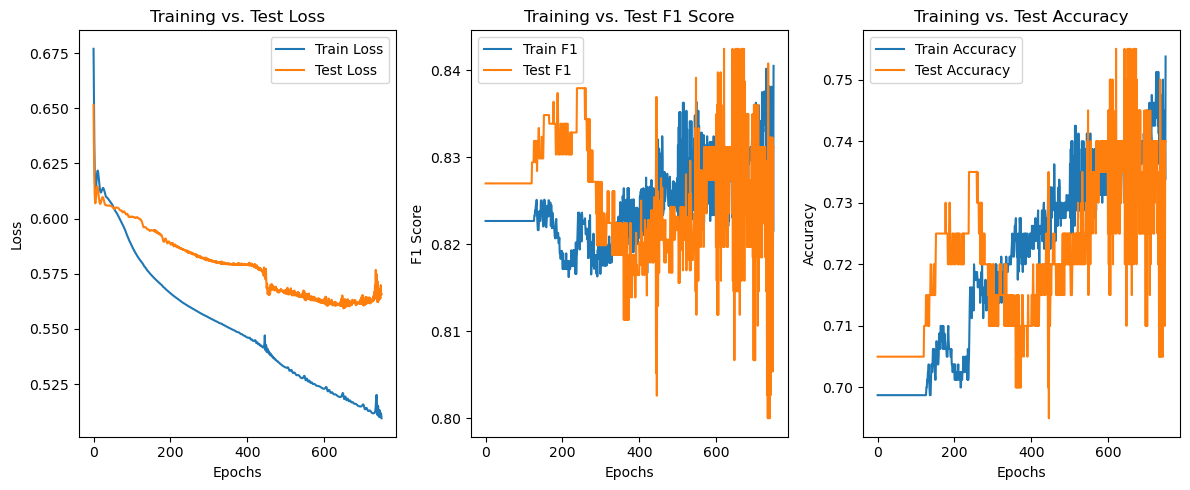

In [5]:
import matplotlib.pyplot as plt
plt.figure(figsize=(12, 5))

# plot Loss
plt.subplot(1, 3, 1)
plt.plot(train_losses, label="Train Loss")
plt.plot(test_losses, label="Test Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Training vs. Test Loss")
plt.legend()

# plot f1_score
plt.subplot(1, 3, 2)
plt.plot(train_f1_scores, label="Train F1")
plt.plot(test_f1_scores, label="Test F1")
plt.xlabel("Epochs")
plt.ylabel("F1 Score")
plt.title("Training vs. Test F1 Score")
plt.legend()

# accuracies
plt.subplot(1, 3, 3)
plt.plot(train_accuracies, label="Train Accuracy")
plt.plot(test_accuracies, label="Test Accuracy")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.title("Training vs. Test Accuracy")
plt.legend()

plt.tight_layout()
plt.show()

## 4. Counterfactual generation:
### 4.1. of one Instance

In [6]:
import dice_ml

df = pd.DataFrame(X, columns=feature_names)
df['target'] = y

dice_data = dice_ml.Data(
    dataframe=df,
    continuous_features=continuous_features,
    categorical_features=categorical_features,
    outcome_name='target'
)

In [7]:
class PyTorchModelWrapper:
    def __init__(self, model):
        self.model = model

    def predict_proba(self, x):
        self.model.eval()
        with torch.no_grad():
            x = x.values
            x = x.astype(np.float64)
            x_tensor = torch.FloatTensor(x)
            logits = self.model(x_tensor)
            probabilities = torch.softmax(logits, dim=1)  
            return probabilities.numpy()

dice_model = dice_ml.Model(
    model=PyTorchModelWrapper(model),
    backend="sklearn",
    model_type='classifier'
)

exp = dice_ml.Dice(
    dice_data,
    dice_model,
    method="genetic"
)


In [8]:

query_instance = X[14:15]
query_df = pd.DataFrame(query_instance, columns=feature_names)


#  generate counterfactuals
dice_exp = exp.generate_counterfactuals(
    query_df,
    total_CFs=3,
    desired_class="opposite",
    features_to_vary = actionable_features
)

dice_exp.visualize_as_dataframe(show_only_changes=True)


100%|██████████| 1/1 [00:00<00:00,  1.11it/s]

Query instance (original outcome : 0)


,Gender,ForeignWorker,Single,Age,LoanDuration,LoanAmount,LoanRateAsPercentOfIncome,YearsAtCurrentHome,NumberOfOtherLoansAtBank,NumberOfLiableIndividuals,...,OtherLoansAtBank,HasCoapplicant,HasGuarantor,OwnsHouse,RentsHouse,Unemployed,YearsAtCurrentJob_lt_1,YearsAtCurrentJob_geq_4,JobClassIsSkilled,target
0,1.0,0.0,0.0,28.0,15.0,1403.0,2.0,4.0,1.0,1.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0



Diverse Counterfactual set (new outcome: 1.0)


,Gender,ForeignWorker,Single,Age,LoanDuration,LoanAmount,LoanRateAsPercentOfIncome,YearsAtCurrentHome,NumberOfOtherLoansAtBank,NumberOfLiableIndividuals,...,OtherLoansAtBank,HasCoapplicant,HasGuarantor,OwnsHouse,RentsHouse,Unemployed,YearsAtCurrentJob_lt_1,YearsAtCurrentJob_geq_4,JobClassIsSkilled,target
0,-,-,-,-,4.0,250.0,-,-,-,-,...,-,-,-,1.0,-,-,-,-,-,1.0
0,-,-,-,-,4.0,250.0,-,-,-,-,...,-,-,-,-,0.0,-,1.0,-,-,1.0
0,-,-,-,-,4.0,250.0,-,-,-,-,...,-,-,-,-,0.0,-,-,-,-,1.0


### 4.2. calculating L1 Distance

In [9]:
cf_df = dice_exp.cf_examples_list[0].final_cfs_df
original = X[11:12]
cf_values = cf_df[feature_names].values
cf_tensor = torch.from_numpy(cf_values).float()
distances = torch.norm(original - cf_tensor, p=1, dim=1)
distance_mean = distances.mean().item()

print("Mean Distance between original and cf values:", distance_mean)
print("distances:", distances)


Mean Distance between original and cf values: 4109.33349609375
distances: tensor([4110., 4108., 4110.])


## 4.3. Calculating the mean value of all L1 Distances of negatively classified instances

In [10]:
X_false_negatives, X_true_negatives, _, _ = split_by_classification(model, X_neg)

query_df = pd.DataFrame(X_true_negatives, columns=feature_names)

dice_exp = exp.generate_counterfactuals(
    query_df,
    total_CFs=3,
    desired_class="opposite",
    features_to_vary=actionable_features
)

100%|██████████| 122/122 [04:49<00:00,  2.38s/it]


In [11]:
all_l1_distances = []
all_l2_distances = []
for i in range(len(X_true_negatives)):
    original = X_true_negatives[i]
    cf_df = dice_exp.cf_examples_list[i].final_cfs_df

    if cf_df is None or cf_df.empty:
        continue

    cf_values = cf_df[feature_names].values
    cf_tensor = torch.from_numpy(cf_values).float()
    l1_distances = torch.norm(original - cf_tensor, p=1, dim=1)
    l2_distances = torch.norm(original - cf_tensor, p=2, dim=1)
    all_l1_distances.extend(l1_distances.tolist())
    all_l2_distances.extend(l2_distances.tolist())

# Compute mean L1 distance
initial_l1_distances = all_l1_distances
initial_l2_distances = all_l2_distances
print(f"Mean L1 distance for negatively classified data using DiCE: {np.mean(all_l1_distances):.2f}")
print(f"Mean L2 distance for negatively classified data using DiCE: {np.mean(all_l2_distances):.2f}")

Mean L1 distance for negatively classified data using DiCE: 2087.52
Mean L2 distance for negatively classified data using DiCE: 2073.30


## 5. Saving the model

In [12]:
from pathlib import Path

# 1. Create models directory
MODEL_PATH = Path("models")
MODEL_PATH.mkdir(parents=True, exist_ok=True)

# 2. Create model save path
MODEL_NAME = "Model_0.pth"
MODEL_SAVE_PATH = MODEL_PATH / MODEL_NAME

# 3. Save the model state dict
print(f"Saving model to: {MODEL_SAVE_PATH}")
torch.save(obj=model.state_dict(),
f=MODEL_SAVE_PATH)

Saving model to: models\01_pytorch_workflow_model_0.pth


## Calculating the initial approximation of recourse

## 5. Modifying the Cost function:

the cost function has this formula

$$  L (X) = BinaryCrossEntropy(D {\scriptstyle train}) -  \frac{\lambda}{|D {\scriptstyle negative}|} \cdot \sum_{x \in D {\scriptstyle negative}} C(x)  $$


with C(x) is an approximation of the Cost of Recourse set to be
$$ C(x) = |G{\scriptstyle class 1} - G{\scriptstyle class 2} |$$

G being the logit of that specific class and the approximation being the difference of the logits

Calculating the counterfactuals for the negatively classified instances mutiple times during the training loop can be very costly. That justifies the use of use of an approximation

In [13]:
lamda = 0.05
epochs = 5000
lr = 0.0000001

loaded_model = NeuralNetwork(X.shape[1], 200, 2)
loaded_model.load_state_dict(torch.load(f=MODEL_SAVE_PATH))

X_train_positive, X_train_negative, _, _ = split_by_classification(loaded_model, X_train)
X_test_positive, X_test_negative, _, _ = split_by_classification(loaded_model, X_test)

loss_fn_1 = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(loaded_model.parameters(), lr=lr)

train_losses = []
test_losses = []

for epoch in range(epochs):
    loaded_model.train()
    y_logits = loaded_model(X_train)
    y_pred = torch.argmax(y_logits, dim=1)
    loss_1 = loss_fn_1(y_logits, y_train.long())

    y_logits_negative = loaded_model(X_train_negative)
    abs_differences = torch.abs(y_logits_negative[:, 0] - y_logits_negative[:, 1])
    loss_2 = torch.mean(abs_differences)

    loss = loss_1 - lamda * loss_2

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    # Evaluation
    loaded_model.eval()
    with torch.inference_mode():
        test_logits = loaded_model(X_test)
        test_pred = torch.argmax(test_logits, dim=1)
        test_loss_1 = loss_fn_1(test_logits, y_test.long())

        y_logits_negative = loaded_model(X_test_negative)
        abs_differences = torch.abs(y_logits_negative[:, 0] - y_logits_negative[:, 1])
        test_loss_2 = torch.mean(abs_differences)

        test_loss = test_loss_1 - lamda * test_loss_2

        f1_score_test = f1_score(y_test, test_pred)

    train_losses.append(loss.item())
    test_losses.append(test_loss.item())

    # Refresh classification split
    if epoch % 10 == 0:
        X_train_positive, X_train_negative, _, _ = split_by_classification(loaded_model, X_train)
        X_test_positive, X_test_negative, _, _ = split_by_classification(loaded_model, X_test)

    # Logging
    if epoch % 1000 == 0:
        print(f"Epoch: {epoch}| Train_Loss: {loss:.5f}| Test loss: {test_loss:.5f}| f1_score_test: {f1_score_test:.5f}")

# best model loading

Epoch: 0| Train_Loss: 0.48204| Test loss: 0.53825| f1_score_test: 0.80537
Epoch: 1000| Train_Loss: 0.48493| Test loss: 0.54356| f1_score_test: 0.78746
Epoch: 2000| Train_Loss: 0.48452| Test loss: 0.54365| f1_score_test: 0.79021
Epoch: 3000| Train_Loss: 0.48425| Test loss: 0.54363| f1_score_test: 0.79021
Epoch: 4000| Train_Loss: 0.48368| Test loss: 0.54436| f1_score_test: 0.79298


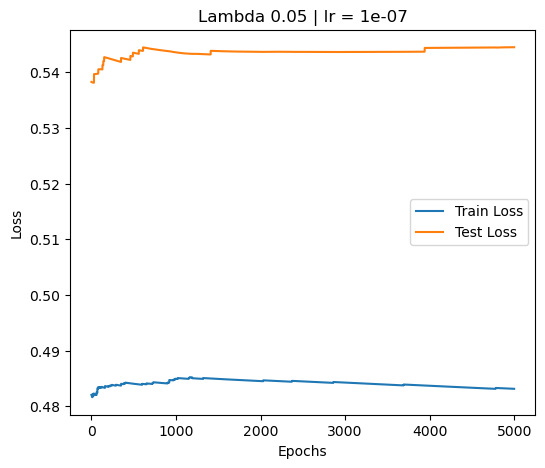

In [14]:
plt.figure(figsize=(6, 5))

plt.plot(train_losses, label="Train Loss")
plt.plot(test_losses, label="Test Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title(f"Lambda {lamda} | lr = {lr}")
plt.legend()

## Testing for different Lamdas



Training for lambda = 0.050
Epoch: 0| Train_Loss: 0.48204| Test loss: 0.53825| f1_score_test: 0.80537
⏹️ Early stopping at epoch 5001 
⏹️ Best Test Loss  0.5436270833015442 
⏹️ Best Epoch  3001 
⏹️ Best_f1_score 0.7902097902097902 


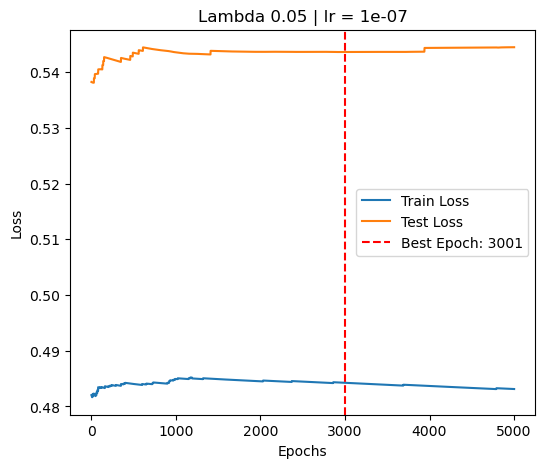


Training for lambda = 0.100
Epoch: 0| Train_Loss: 0.45320| Test loss: 0.50527| f1_score_test: 0.80537
Epoch: 10000| Train_Loss: 0.45601| Test loss: 0.51563| f1_score_test: 0.75277
⏹️ Early stopping at epoch 12540 
⏹️ Best Test Loss  0.5139719843864441 
⏹️ Best Epoch  8540 
⏹️ Best_f1_score 0.7619047619047619 


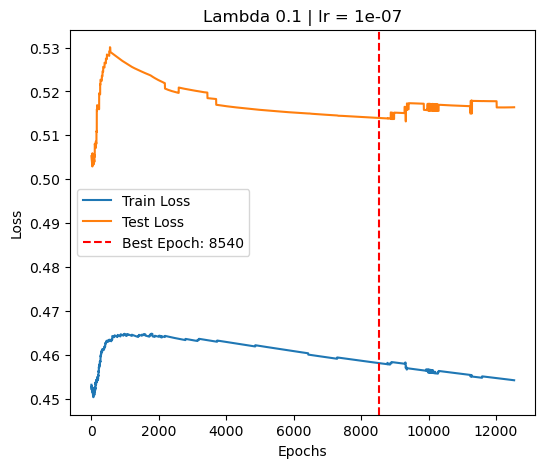


Training for lambda = 0.150
Epoch: 0| Train_Loss: 0.42435| Test loss: 0.47229| f1_score_test: 0.80537
Epoch: 10000| Train_Loss: 0.42908| Test loss: 0.49115| f1_score_test: 0.74510
Epoch: 20000| Train_Loss: 0.41728| Test loss: 0.48294| f1_score_test: 0.74219
Epoch: 30000| Train_Loss: 0.40947| Test loss: 0.47414| f1_score_test: 0.74131
Epoch: 40000| Train_Loss: 0.40318| Test loss: 0.46866| f1_score_test: 0.74330
⏹️ Early stopping at epoch 45800 
⏹️ Best Test Loss  0.46469879150390625 
⏹️ Best Epoch  35800 
⏹️ Best_f1_score 0.7480916030534351 


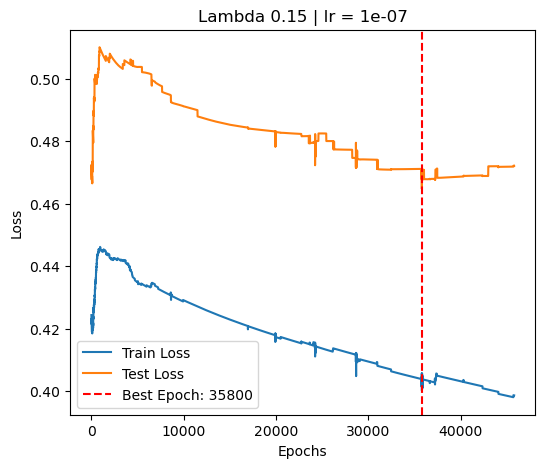


Training for lambda = 0.200
Epoch: 0| Train_Loss: 0.39551| Test loss: 0.43931| f1_score_test: 0.80537
Epoch: 10000| Train_Loss: 0.40486| Test loss: 0.46565| f1_score_test: 0.70000
Epoch: 20000| Train_Loss: 0.38263| Test loss: 0.44308| f1_score_test: 0.71837
Epoch: 30000| Train_Loss: 0.37237| Test loss: 0.43305| f1_score_test: 0.72358
Epoch: 40000| Train_Loss: 0.36194| Test loss: 0.43163| f1_score_test: 0.72358
Epoch: 50000| Train_Loss: 0.34937| Test loss: 0.44003| f1_score_test: 0.72653
⏹️ Early stopping at epoch 51440 
⏹️ Best Test Loss  0.42383477091789246 
⏹️ Best Epoch  36440 
⏹️ Best_f1_score 0.7258064516129032 


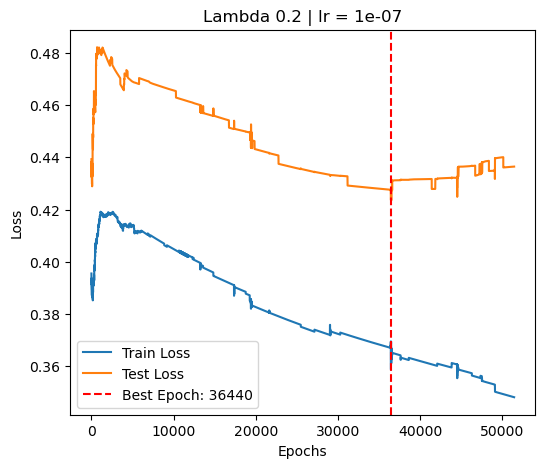


Training for lambda = 0.250
Epoch: 0| Train_Loss: 0.36667| Test loss: 0.40633| f1_score_test: 0.80537
Epoch: 10000| Train_Loss: 0.37989| Test loss: 0.42806| f1_score_test: 0.66957
Epoch: 20000| Train_Loss: 0.35064| Test loss: 0.40440| f1_score_test: 0.68670
Epoch: 30000| Train_Loss: 0.33307| Test loss: 0.39648| f1_score_test: 0.68670
Epoch: 40000| Train_Loss: 0.31429| Test loss: 0.38260| f1_score_test: 0.68936
Epoch: 50000| Train_Loss: 0.31053| Test loss: 0.37224| f1_score_test: 0.70339
Epoch: 60000| Train_Loss: 0.30140| Test loss: 0.36941| f1_score_test: 0.69787
Epoch: 70000| Train_Loss: 0.29540| Test loss: 0.36358| f1_score_test: 0.69787
Epoch: 80000| Train_Loss: 0.27857| Test loss: 0.36008| f1_score_test: 0.69787
Epoch: 90000| Train_Loss: 0.26241| Test loss: 0.36237| f1_score_test: 0.69231
Epoch: 100000| Train_Loss: 0.25023| Test loss: 0.35421| f1_score_test: 0.69787
Epoch: 110000| Train_Loss: 0.22888| Test loss: 0.35753| f1_score_test: 0.69787
Epoch: 120000| Train_Loss: 0.22285| T

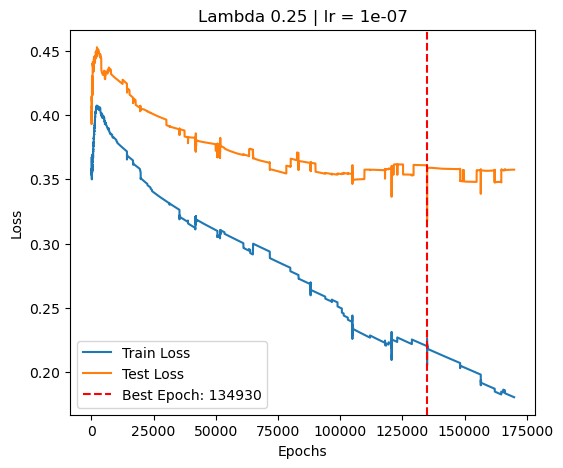


Training for lambda = 0.300
Epoch: 0| Train_Loss: 0.33783| Test loss: 0.37335| f1_score_test: 0.80537
Epoch: 10000| Train_Loss: 0.35185| Test loss: 0.38906| f1_score_test: 0.61818
Epoch: 20000| Train_Loss: 0.33002| Test loss: 0.37262| f1_score_test: 0.62727
Epoch: 30000| Train_Loss: 0.30787| Test loss: 0.36150| f1_score_test: 0.63636
Epoch: 40000| Train_Loss: 0.28872| Test loss: 0.35776| f1_score_test: 0.63014
Epoch: 50000| Train_Loss: 0.26695| Test loss: 0.34684| f1_score_test: 0.63636
Epoch: 60000| Train_Loss: 0.25010| Test loss: 0.33525| f1_score_test: 0.64253
Epoch: 70000| Train_Loss: 0.23191| Test loss: 0.31100| f1_score_test: 0.65179
Epoch: 80000| Train_Loss: 0.22010| Test loss: 0.29185| f1_score_test: 0.66372
Epoch: 90000| Train_Loss: 0.20695| Test loss: 0.30136| f1_score_test: 0.65179
Epoch: 100000| Train_Loss: 0.18813| Test loss: 0.28726| f1_score_test: 0.65778
Epoch: 110000| Train_Loss: 0.17686| Test loss: 0.28142| f1_score_test: 0.65778
Epoch: 120000| Train_Loss: 0.15886| T

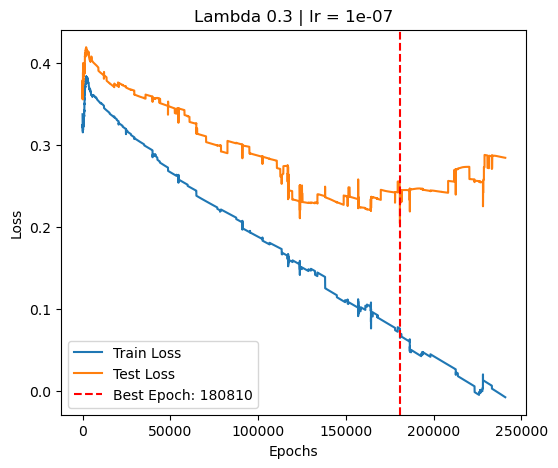

In [18]:
lambdas = [0.05,0.1,0.15,0.2,0.25,0.3]
lr = 0.0000001
patiences = [2000, 4000, 10000, 15000, 35000, 60000]
starting_epoch =3000
delta = 0.001

model1= NeuralNetwork(X.shape[1], 200, 2)
model2= NeuralNetwork(X.shape[1], 200, 2)
model3= NeuralNetwork(X.shape[1], 200, 2)
model4= NeuralNetwork(X.shape[1], 200, 2)
model5= NeuralNetwork(X.shape[1], 200, 2)
model6= NeuralNetwork(X.shape[1], 200, 2)
models = [model1, model2, model3, model4, model5, model6]
best_f1_scores = []

for lamda, best_model, patience in zip(lambdas, models, patiences):
    epochs = 600000

    delta = 0.001
    best_test_loss = float('inf')
    counter = 0


    print(f"\nTraining for lambda = {lamda:.3f}")

    loaded_model = NeuralNetwork(X.shape[1], 200, 2)
    loaded_model.load_state_dict(torch.load(f=MODEL_SAVE_PATH))


    X_train_positive, X_train_negative, _, _ = split_by_classification(loaded_model, X_train)
    X_test_positive, X_test_negative, _, _ = split_by_classification(loaded_model, X_test)

    loss_fn_1 = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(loaded_model.parameters(), lr= lr)

    train_losses = []
    test_losses = []
    for epoch in range(epochs):

        # Refresh classification split
        if epoch % 10 == 0:
            X_train_positive, X_train_negative, _, _ = split_by_classification(loaded_model, X_train)
            X_test_positive, X_test_negative, _, _ = split_by_classification(loaded_model, X_test)

        loaded_model.train()
        y_logits = loaded_model(X_train)
        y_pred = torch.argmax(y_logits, dim=1)
        loss_1 = loss_fn_1(y_logits, y_train.long())

        y_logits_negative = loaded_model(X_train_negative)
        abs_differences = torch.abs(y_logits_negative[:, 0] - y_logits_negative[:, 1])
        loss_2 = torch.mean(abs_differences)

        loss = loss_1 - lamda * loss_2

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # Evaluation
        loaded_model.eval()
        with torch.inference_mode():
            test_logits = loaded_model(X_test)
            test_pred = torch.argmax(test_logits, dim=1)
            test_loss_1 = loss_fn_1(test_logits, y_test.long())

            y_logits_negative = loaded_model(X_test_negative)
            abs_differences = torch.abs(y_logits_negative[:, 0] - y_logits_negative[:, 1])
            test_loss_2 = torch.mean(abs_differences)
            test_loss = test_loss_1 - lamda * test_loss_2

            f1_score_test = f1_score(y_test, test_pred)


        train_losses.append(loss.item())
        test_losses.append(test_loss.item())


        # Logging
        if epoch % 10000 == 0:
            print(f"Epoch: {epoch}| Train_Loss: {loss:.5f}| Test loss: {test_loss:.5f}| f1_score_test: {f1_score_test:.5f}")

        if epoch > starting_epoch:
            # early stopping
            if test_loss.item() < best_test_loss - delta:
                best_test_loss = test_loss.item()
                best_epoch = epoch
                best_f1_score = f1_score_test
                counter = 0
                best_model_state = loaded_model.state_dict()
            else:
                counter += 1
                if counter >= patience:
                    print(f"⏹️ Early stopping at epoch {epoch} ")
                    print(f"⏹️ Best Test Loss  {best_test_loss} ")
                    print(f"⏹️ Best Epoch  {best_epoch} ")
                    print(f"⏹️ Best_f1_score {best_f1_score} ")
                    best_f1_scores.append(best_f1_score)

                    plt.figure(figsize=(6, 5))

                    plt.plot(train_losses, label="Train Loss")
                    plt.plot(test_losses, label="Test Loss")
                    plt.axvline(x=best_epoch, color='r', linestyle='--', label=f"Best Epoch: {best_epoch}")
                    plt.xlabel("Epochs")
                    plt.ylabel("Loss")
                    plt.title(f"Lambda {lamda} | lr = {lr}")
                    plt.legend()

                    plt.show()

                    break

    best_model.load_state_dict(best_model_state)


In [32]:
for (model, lamda) in zip(models, lambdas):
    model_save_path = f"models/model_lambda_{lamda:.2f}.pth"
    torch.save(model.state_dict(), model_save_path)

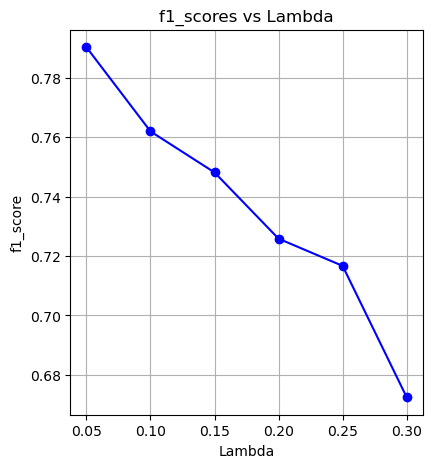

In [19]:
plt.figure(figsize=(10, 5))
# f1_score
plt.subplot(1, 2, 1)
plt.plot(lambdas, best_f1_scores, marker='o', color='blue')
plt.title("f1_scores vs Lambda")
plt.xlabel("Lambda")
plt.ylabel("f1_score")
plt.grid(True)


### Evaluation with DICE

In [20]:
cost_of_recourses_l1 = []
cost_of_recourses_l2 = []

for best_model in models:

    X_false_negatives, X_true_negatives, _, _ = split_by_classification(best_model, X_neg)

    dice_model = dice_ml.Model(
        model=PyTorchModelWrapper(best_model),
        backend="sklearn",
        model_type='classifier'
    )

    exp = dice_ml.Dice(
        dice_data,
        dice_model,
        method="genetic"
    )

    query_df = pd.DataFrame(X_true_negatives.numpy(), columns=feature_names)

    dice_exp = exp.generate_counterfactuals(
        query_df,
        total_CFs=3,
        desired_class="opposite",
        features_to_vary=actionable_features
    )

    all_l1_distances = []
    all_l2_distances = []
    for i in range(len(X_true_negatives)):
        original = X_true_negatives[i]
        cf_df = dice_exp.cf_examples_list[i].final_cfs_df

        if cf_df is None or cf_df.empty:
            continue

        cf_values = cf_df[feature_names].values
        cf_tensor = torch.from_numpy(cf_values).float()
        l1_distances = torch.norm(original - cf_tensor, p=1, dim=1)
        l2_distances = torch.norm(original - cf_tensor, p=2, dim=1)
        all_l1_distances.extend(l1_distances.tolist())
        all_l2_distances.extend(l2_distances.tolist())


    # Compute mean L1 distance
    cost_of_recourses_l1.append(all_l1_distances)
    cost_of_recourses_l2.append(all_l2_distances)

    print(f"Mean L1 distance for negatively classified data using DiCE: {np.mean(all_l1_distances):.2f}")
    print(f"Mean L2 distance for negatively classified data using DiCE: {np.mean(all_l2_distances):.2f}")

100%|██████████| 155/155 [11:20<00:00,  4.39s/it]


Mean L1 distance for negatively classified data using DiCE: 1974.74
Mean L2 distance for negatively classified data using DiCE: 1959.59


100%|██████████| 183/183 [10:06<00:00,  3.31s/it]


Mean L1 distance for negatively classified data using DiCE: 2233.67
Mean L2 distance for negatively classified data using DiCE: 2217.23


100%|██████████| 210/210 [20:58<00:00,  5.99s/it] 


Mean L1 distance for negatively classified data using DiCE: 2301.94
Mean L2 distance for negatively classified data using DiCE: 2285.90


100%|██████████| 228/228 [05:44<00:00,  1.51s/it] 


Mean L1 distance for negatively classified data using DiCE: 2591.52
Mean L2 distance for negatively classified data using DiCE: 2574.45


100%|██████████| 248/248 [06:45<00:00,  1.63s/it]


Mean L1 distance for negatively classified data using DiCE: 2326.72
Mean L2 distance for negatively classified data using DiCE: 2310.31


100%|██████████| 258/258 [08:02<00:00,  1.87s/it]


Mean L1 distance for negatively classified data using DiCE: 2447.18
Mean L2 distance for negatively classified data using DiCE: 2430.18


In [21]:
cost_of_recourses_l1.insert(0,initial_l1_distances)
cost_of_recourses_l2.insert(0,initial_l2_distances)
lambdas.insert(0,0)

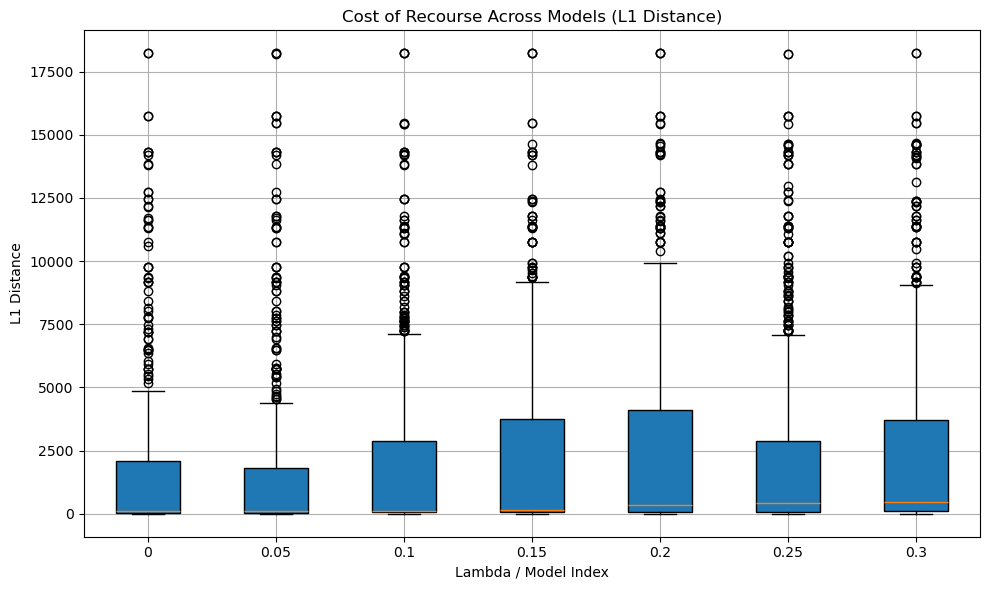

In [22]:
plt.figure(figsize=(10, 6))
plt.boxplot(cost_of_recourses_l1,patch_artist=True, tick_labels=lambdas)
plt.title("Cost of Recourse Across Models (L1 Distance)")
plt.xlabel("Lambda / Model Index")
plt.ylabel("L1 Distance")
plt.grid(True)
plt.tight_layout()
plt.show()

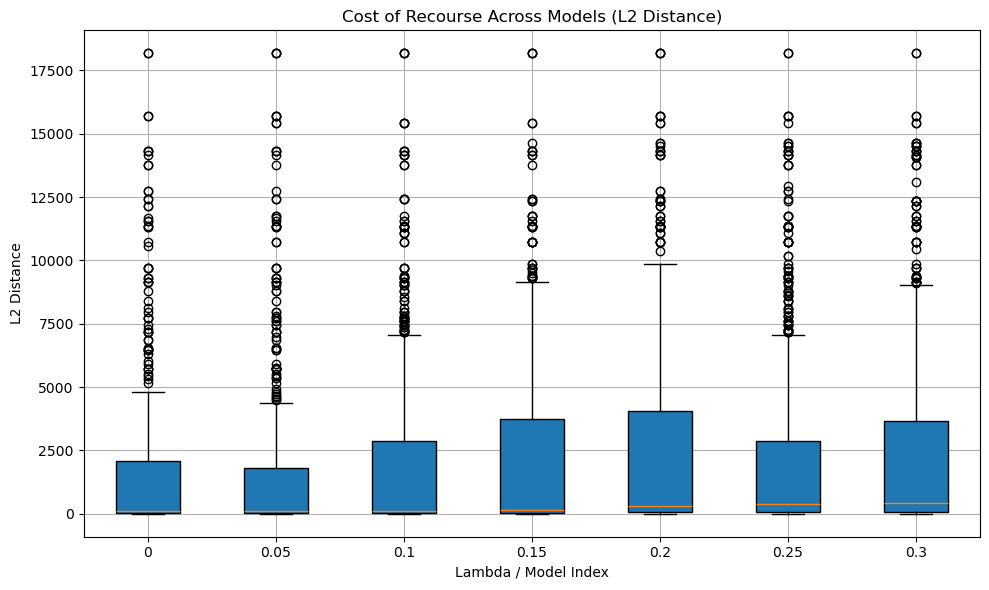

In [23]:
plt.figure(figsize=(10, 6))
plt.boxplot(cost_of_recourses_l2,patch_artist=True, tick_labels=lambdas)
plt.title("Cost of Recourse Across Models (L2 Distance)")
plt.xlabel("Lambda / Model Index")
plt.ylabel("L2 Distance")
plt.grid(True)
plt.tight_layout()
plt.show()

Why cant we use the actual recourse in the training .
Because the recourse given by dice is not differentiable.

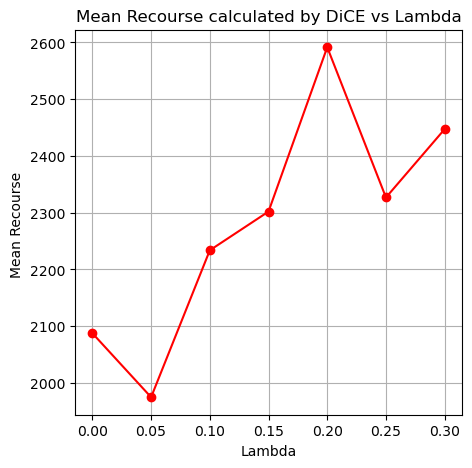

In [24]:
l1_means = [np.mean(sublist) for sublist in cost_of_recourses_l1]

## Plotting of the mean of Recourse genereated by dice After the Training with different Lambdas
plt.figure(figsize=(5, 5))
plt.plot(lambdas, l1_means, marker='o', color='red')
plt.title("Mean Recourse calculated by DiCE vs Lambda")
plt.xlabel("Lambda")
plt.ylabel("Mean Recourse ")
plt.grid(True)


[2073.30030078172, 1959.5915199612316, 2217.229942990405, 2285.904863297263, 2574.4456639377254, 2310.313624328608, 2430.1838376952455]


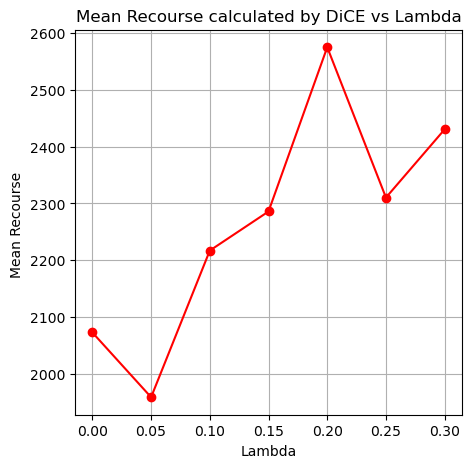

In [25]:
l2_means = [np.mean(sublist) for sublist in cost_of_recourses_l2]
print(l2_means)

## Plotting of the mean of Recourse genereated by dice After the Training with different Lambdas
plt.figure(figsize=(5, 5))
plt.plot(lambdas, l2_means, marker='o', color='red')
plt.title("Mean Recourse calculated by DiCE vs Lambda")
plt.xlabel("Lambda")
plt.ylabel("Mean Recourse ")
plt.grid(True)

## now we caluclate the counterfactuals only for instances that are classified as negative by all the models

In [26]:
# fist we calculate this subset
models.insert(0,model)

In [27]:
# fist we calculate this subset
_, commun_negatives, _, _ = split_by_classification(model, X_neg)

for current_model in models:
    _, commun_negatives, _, _ = split_by_classification(current_model, commun_negatives)

print(len(commun_negatives))

122


In [28]:
cost_of_recourses_l1 = []
cost_of_recourses_l2 = []

for best_model in models:

    dice_model = dice_ml.Model(
        model=PyTorchModelWrapper(best_model),
        backend="sklearn",
        model_type='classifier'
    )

    exp = dice_ml.Dice(
        dice_data,
        dice_model,
        method="genetic"
    )

    query_df = pd.DataFrame(commun_negatives.numpy(), columns=feature_names)

    dice_exp = exp.generate_counterfactuals(
        query_df,
        total_CFs=3,
        desired_class="opposite",
        features_to_vary=actionable_features
    )

    all_l1_distances = []
    all_l2_distances = []
    for i in range(len(commun_negatives)):
        original = commun_negatives[i]
        cf_df = dice_exp.cf_examples_list[i].final_cfs_df

        if cf_df is None or cf_df.empty:
            continue

        cf_values = cf_df[feature_names].values
        cf_tensor = torch.from_numpy(cf_values).float()
        l1_distances = torch.norm(original - cf_tensor, p=1, dim=1)
        l2_distances = torch.norm(original - cf_tensor, p=2, dim=1)
        all_l1_distances.extend(l1_distances.tolist())
        all_l2_distances.extend(l2_distances.tolist())


    # Compute mean L1 distance
    cost_of_recourses_l1.append(all_l1_distances)
    cost_of_recourses_l2.append(all_l2_distances)

    print(f"Mean L1 distance for negatively classified data using DiCE: {np.mean(all_l1_distances):.2f}")
    print(f"Mean L2 distance for negatively classified data using DiCE: {np.mean(all_l2_distances):.2f}")

100%|██████████| 122/122 [05:39<00:00,  2.78s/it]


Mean L1 distance for negatively classified data using DiCE: 1967.73
Mean L2 distance for negatively classified data using DiCE: 1953.58


100%|██████████| 122/122 [10:11<00:00,  5.01s/it]


Mean L1 distance for negatively classified data using DiCE: 2486.12
Mean L2 distance for negatively classified data using DiCE: 2470.14


100%|██████████| 122/122 [06:46<00:00,  3.33s/it]


Mean L1 distance for negatively classified data using DiCE: 2704.55
Mean L2 distance for negatively classified data using DiCE: 2687.84


100%|██████████| 122/122 [09:20<00:00,  4.59s/it]


Mean L1 distance for negatively classified data using DiCE: 2927.46
Mean L2 distance for negatively classified data using DiCE: 2909.45


100%|██████████| 122/122 [02:59<00:00,  1.47s/it]


Mean L1 distance for negatively classified data using DiCE: 3171.41
Mean L2 distance for negatively classified data using DiCE: 3152.41


100%|██████████| 122/122 [04:42<00:00,  2.32s/it]


Mean L1 distance for negatively classified data using DiCE: 3117.39
Mean L2 distance for negatively classified data using DiCE: 3098.26


100%|██████████| 122/122 [03:39<00:00,  1.80s/it]

Mean L1 distance for negatively classified data using DiCE: 3358.54
Mean L2 distance for negatively classified data using DiCE: 3338.44


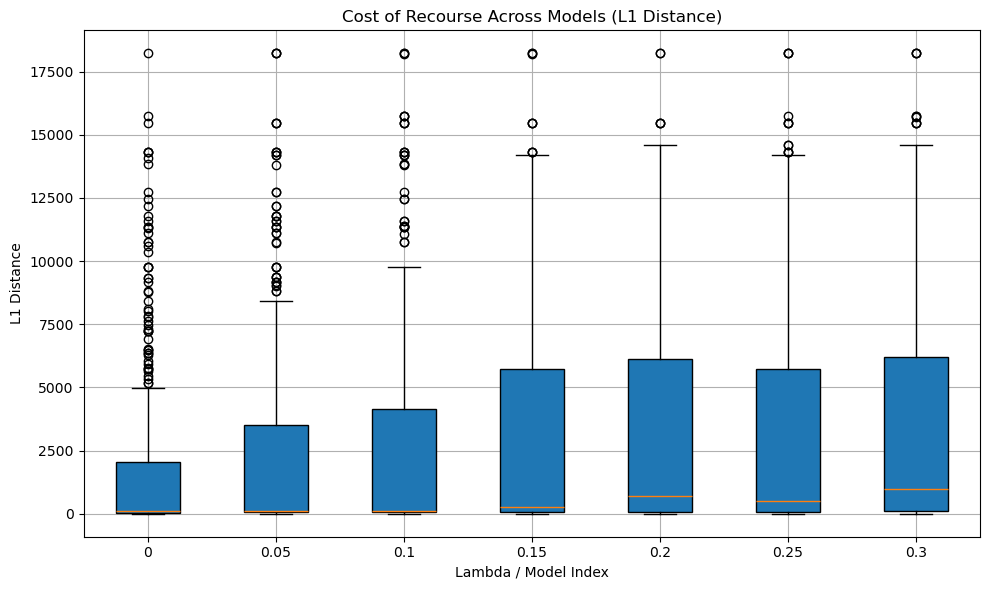

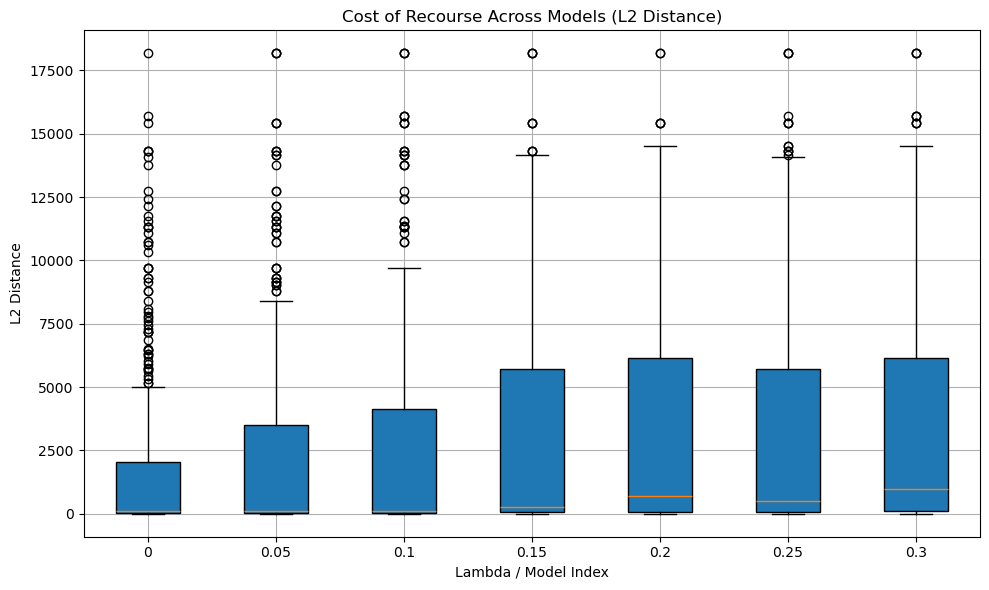

In [29]:
plt.figure(figsize=(10, 6))
plt.boxplot(cost_of_recourses_l1,patch_artist=True, tick_labels=lambdas)
plt.title("Cost of Recourse Across Models (L1 Distance)")
plt.xlabel("Lambda / Model Index")
plt.ylabel("L1 Distance")
plt.grid(True)
plt.tight_layout()
plt.show()

plt.figure(figsize=(10, 6))
plt.boxplot(cost_of_recourses_l2,patch_artist=True, tick_labels=lambdas)
plt.title("Cost of Recourse Across Models (L2 Distance)")
plt.xlabel("Lambda / Model Index")
plt.ylabel("L2 Distance")
plt.grid(True)
plt.tight_layout()
plt.show()

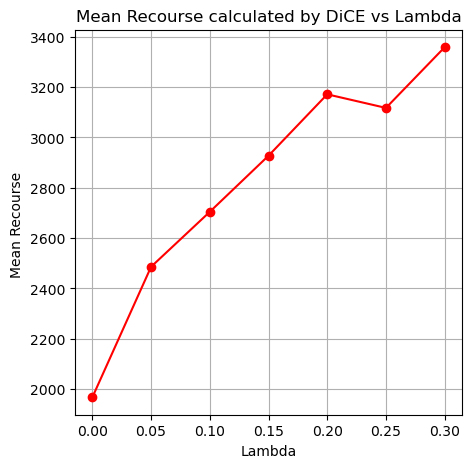

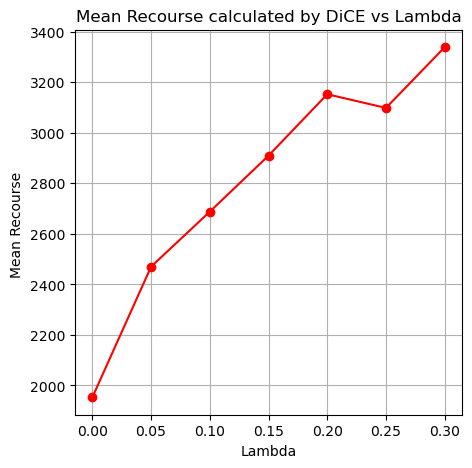

In [30]:
l1_means = [np.mean(sublist) for sublist in cost_of_recourses_l1]
## Plotting of the mean of Recourse genereated by dice After the Training with different Lambdas
plt.figure(figsize=(5, 5))
plt.plot(lambdas, l1_means, marker='o', color='red')
plt.title("Mean Recourse calculated by DiCE vs Lambda")
plt.xlabel("Lambda")
plt.ylabel("Mean Recourse ")
plt.grid(True)


l2_means = [np.mean(sublist) for sublist in cost_of_recourses_l2]
## Plotting of the mean of Recourse genereated by dice After the Training with different Lambdas
plt.figure(figsize=(5, 5))
plt.plot(lambdas, l2_means, marker='o', color='red')
plt.title("Mean Recourse calculated by DiCE vs Lambda")
plt.xlabel("Lambda")
plt.ylabel("Mean Recourse ")
plt.grid(True)
